In [1]:
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END, MessagesState
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.graph.message import add_messages
from langgraph.checkpoint.postgres import PostgresSaver
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_core.tools import Tool
import streamlit as st
from psycopg import connect
from pathlib import Path


In [2]:
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
DB_URI = os.getenv("DB_URI")

llm = ChatGroq(model = "openai/gpt-oss-120b", api_key = groq_api_key)

search_tool = DuckDuckGoSearchRun()

llm_with_tools = llm.bind_tools([search_tool])

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [28]:
@st.cache_resource
def init_checkpointer():
    # Step 1: Create DB tables if not exist
    with PostgresSaver.from_conn_string(DB_URI) as setup_saver:
        setup_saver.setup()
    # Step 2: Create a persistent connection
    conn = connect(DB_URI)
    return PostgresSaver(conn)  # persistent checkpointer

checkpointer = init_checkpointer()

In [4]:
def chat_node(state: AgentState): 
    response = llm_with_tools.invoke(state['messages'])
    return {'messages': [response]}

In [5]:
tool_node = ToolNode([search_tool])

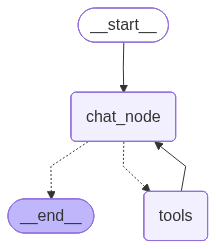

In [7]:
graph = StateGraph(AgentState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges(
    "chat_node",
    tools_condition
)

graph.add_edge('tools', "chat_node")

graph.compile()

In [33]:
config = {
    "configurable": {
        "thread_id": "my_thread_8"
    }
}

In [34]:
workflow.invoke({"messages": [HumanMessage(content="add 2 + 2")]},config=config)

{'messages': [HumanMessage(content='add 2 + 2', additional_kwargs={}, response_metadata={}, id='1a9384f3-989d-493b-9504-43ed5ebab440'),
  AIMessage(content='2\u202f+\u202f2\u202f=\u202f4.', additional_kwargs={'reasoning_content': 'User asks "add 2 + 2". Simple arithmetic. Answer: 4.'}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 154, 'total_tokens': 192, 'completion_time': 0.079472983, 'prompt_time': 0.006003788, 'queue_time': 0.004257587, 'total_time': 0.085476771, 'completion_tokens_details': {'reasoning_tokens': 19}}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_a28df4bce5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--88fb4387-d6a3-416e-b1d8-a31af4a0b118-0', usage_metadata={'input_tokens': 154, 'output_tokens': 38, 'total_tokens': 192, 'output_token_details': {'reasoning': 19}})]}

In [35]:
list(workflow.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='add 2 + 2', additional_kwargs={}, response_metadata={}, id='1a9384f3-989d-493b-9504-43ed5ebab440'), AIMessage(content='2\u202f+\u202f2\u202f=\u202f4.', additional_kwargs={'reasoning_content': 'User asks "add 2 + 2". Simple arithmetic. Answer: 4.'}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 154, 'total_tokens': 192, 'completion_time': 0.079472983, 'prompt_time': 0.006003788, 'queue_time': 0.004257587, 'total_time': 0.085476771, 'completion_tokens_details': {'reasoning_tokens': 19}}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_a28df4bce5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--88fb4387-d6a3-416e-b1d8-a31af4a0b118-0', usage_metadata={'input_tokens': 154, 'output_tokens': 38, 'total_tokens': 192, 'output_token_details': {'reasoning': 19}})]}, next=(), config={'configurable': {'thread_id': 'my_thread_8', 'che

In [36]:
all_threads = set()
def retrieve_all_threads():
    for checkpoint in checkpointer.list(None):
        all_threads.add(checkpoint.config['configurable']['thread_id'])
    return list(all_threads)

In [37]:
retrieve_all_threads()

['my_thread_5', 'my_thread_2', 'my_thread_8']

In [ ]:
all_threads = set()
def retrieve_all_threads():   

for checkpoint in checkpointer.list(None):

all_threads.add(checkpoint.config['configurable']['thread_id'])
    return list(all_threads)
    
print(retrieve_all_threads())

In [77]:
workflow.invoke({"messages": [HumanMessage(content="who is the current president of usa")]},config=config)

{'messages': [HumanMessage(content='what is my name', additional_kwargs={}, response_metadata={}, id='372e72a8-b0c8-4e0e-b6d5-58ae7e9e4095'),
  AIMessage(content='I don’t actually have any information about your name. Could you let me know what you’d like me to call you?', additional_kwargs={'reasoning_content': 'The user asks "what is my name". The assistant doesn\'t have any prior context. There\'s no stored user name. Could try to ask for clarification, but the user likely expects the assistant to know. We don\'t have that info. So we should respond politely that we don\'t know.'}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 152, 'total_tokens': 243, 'completion_time': 0.186582187, 'prompt_time': 0.005732854, 'queue_time': 0.0040685, 'total_time': 0.192315041, 'completion_tokens_details': {'reasoning_tokens': 57}}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_70d048ba3c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logpro